In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import theano.tensor as tt
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
%matplotlib inline
palette = 'muted'
sns.set_palette(palette)
sns.set_color_codes(palette)
np.set_printoptions(precision=2)


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Kernelized Regression

Text(0, 0.5, '$f(x)$')

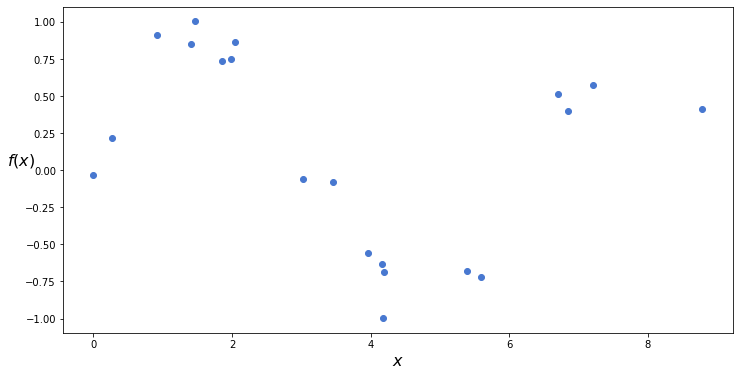

In [2]:
np.random.seed(1)

plt.figure(figsize=(12, 6))

x = np.random.uniform(0, 10, size=20)
y = np.random.normal(np.sin(x), 0.2)
plt.plot(x, y, 'o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)

In [3]:
def gauss_kernel(x, n_knots):
    """ Simple Gaussian radial kernel """
    knots, w = np.linspace(x.min(), x.max(), n_knots), 2
    return np.array([np.exp(-(x-k)**2/w) for k in knots])


In [4]:
n_knots = 5

In [6]:
with pm.Model() as kernel_model:
    gamma = pm.Cauchy('gamma', alpha=0, beta=1, shape=n_knots)
    sd = pm.Uniform('sd',0,  10)
    mu = pm.math.dot(gamma, gauss_kernel(x, n_knots))
    yl = pm.Normal('yl', mu=mu, sd=sd, observed=y)
    
    kernel_trace = pm.sampling.sample(10000, step=pm.Metropolis(), return_inferencedata=False)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sd]
>Metropolis: [gamma]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 48 seconds.
The number of effective samples is smaller than 10% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'gamma'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

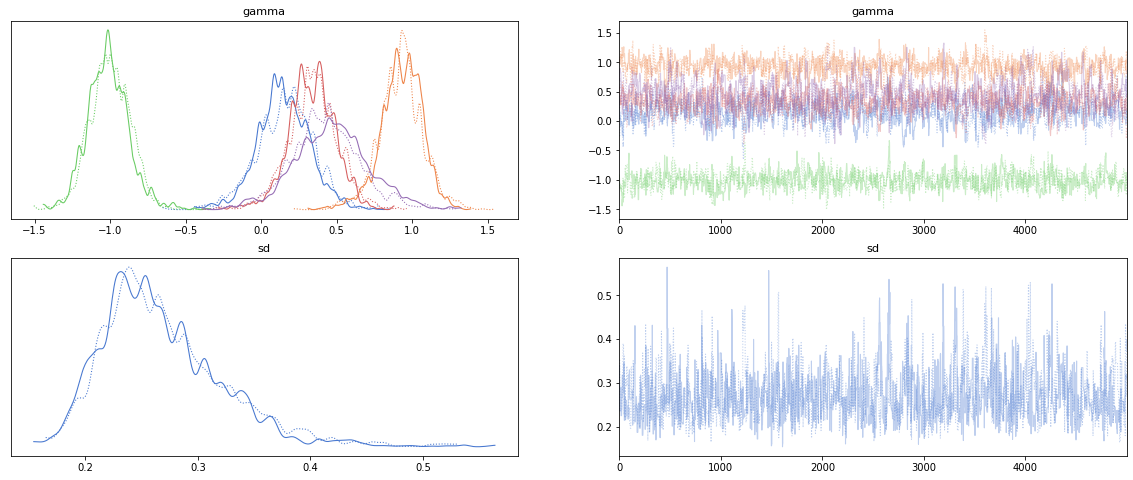

In [7]:
chain = kernel_trace[5000:]
pm.plot_trace(chain, figsize=(20, 8))

In [8]:
pm.summary(chain)

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma[0],0.155,0.181,-0.168,0.507,0.009,0.007,369.0,604.0,1.00
gamma[1],0.928,0.143,0.654,1.198,0.006,0.004,563.0,738.0,1.00
gamma[2],-1.007,0.136,-1.266,-0.770,0.006,0.004,577.0,817.0,1.00
gamma[3],0.339,0.161,0.043,0.641,0.007,0.005,500.0,730.0,1.00
gamma[4],0.448,0.242,-0.023,0.911,0.014,0.010,291.0,430.0,1.01
sd,0.269,0.054,0.185,0.371,0.002,0.002,716.0,798.0,1.00


e:\Code\Algorithmic-Trading\env\lib\site-packages\pymc3\sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


Text(0, 0.5, '$f(x)$')

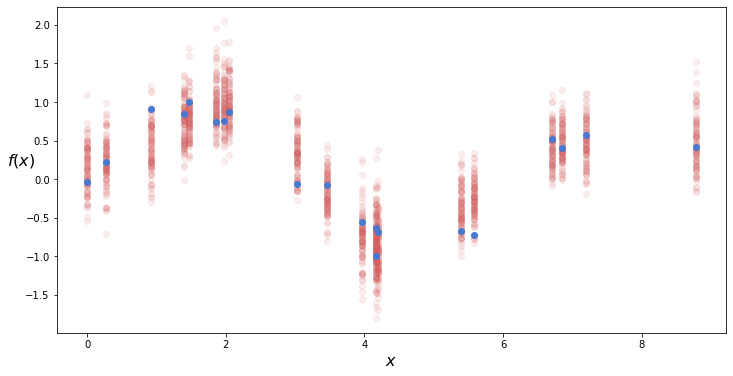

In [9]:
ppc = pm.sampling.sample_posterior_predictive(chain, samples=100, model=kernel_model)

plt.figure(figsize=(12, 6))
plt.plot(x, ppc['yl'].T, 'ro', alpha=0.1)

plt.plot(x, y, 'bo')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)

Text(0, 0.5, '$f(x)$')

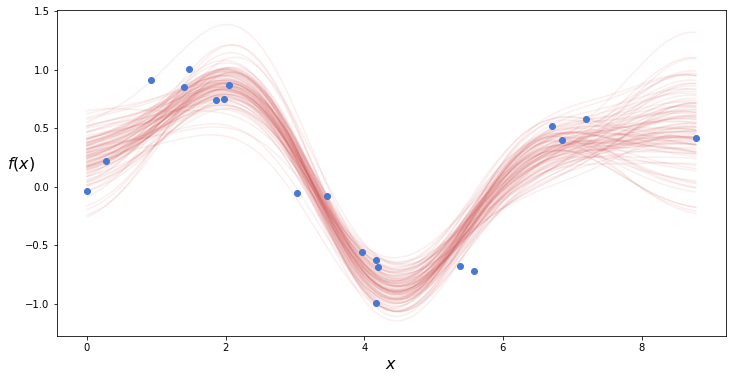

In [10]:
new_x = np.linspace(x.min(), x.max(), 100)
k = gauss_kernel(new_x, n_knots)
gamma_pred = chain['gamma']

plt.figure(figsize=(12, 6))

for i in range(100):
    idx = np.random.randint(0, len(gamma_pred))
    y_pred = np.dot(gamma_pred[idx], k)
    plt.plot(new_x, y_pred, 'r-', alpha=0.1)
plt.plot(x, y, 'bo')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)

## Gaussian Processes

In [11]:
squared_distance = lambda x, y: np.array([[(x[i] - y[j])**2 for i in range(len(x))] for j in range(len(y))])

Text(0, 0.5, '$f(x)$')

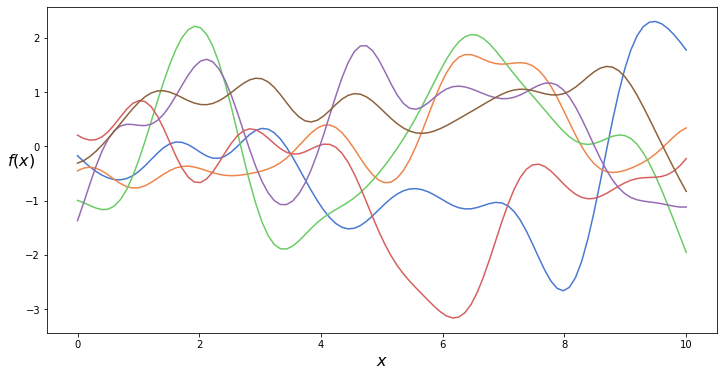

In [13]:
np.random.seed(1)

plt.figure(figsize=(12, 6))

test_points = np.linspace(0, 10, 100)

cov = np.exp(-squared_distance(test_points, test_points))

plt.plot(test_points, stats.multivariate_normal.rvs(cov=cov, size=6).T)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)

Text(0, 0.5, '$f(x)$')

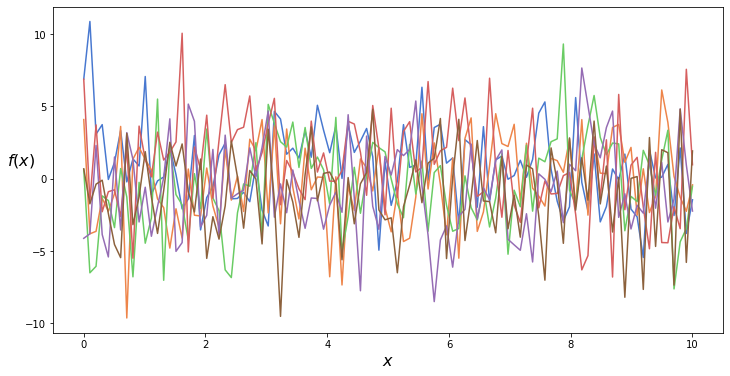

In [31]:
np.random.seed(1)
plt.figure(figsize=(12, 6))

eta, rho, sigma = 1, 0.5, 0.03

D = squared_distance(test_points, test_points)
cov = eta * np.exp(-rho * D)
diag = eta * sigma

np.fill_diagonal(cov, diag)

for i in range(6):
    min_eig = np.min(np.real(np.linalg.eigvals(cov)))
    if min_eig < 0:
        cov -= 10*min_eig * np.eye(*cov.shape)

    plt.plot(test_points, stats.multivariate_normal.rvs(cov=cov))
    
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)

Text(0, 0.5, '$f(x)$')

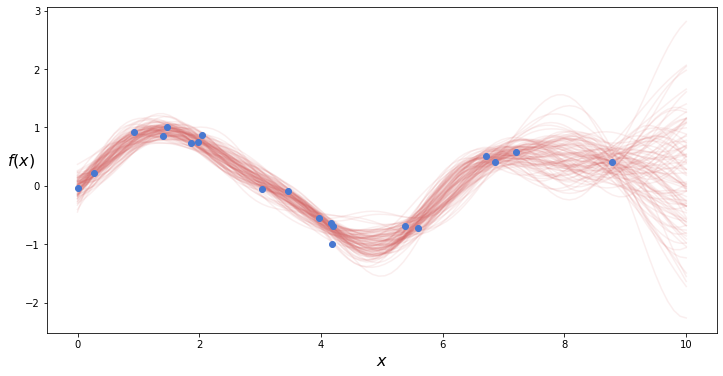

In [29]:
np.random.seed(1)

plt.figure(figsize=(12, 6))

K_oo = eta * np.exp(-rho * D) 

D_x = squared_distance(x, x)
K = eta * np.exp(-rho * D_x)
diag_x = eta + sigma
np.fill_diagonal(K, diag_x)

D_off_diag = squared_distance(x, test_points)
K_o = eta * np.exp(-rho * D_off_diag)

# Posterior mean
mu_post = np.dot(np.dot(K_o, np.linalg.inv(K)), y)

# Posterior covariance
SIGMA_post = K_oo - np.dot(np.dot(K_o, np.linalg.inv(K)), K_o.T)

for i in range(100):
    fx = stats.multivariate_normal.rvs(mean=mu_post, cov=SIGMA_post)
    plt.plot(test_points, fx, 'r-', alpha=0.1)

plt.plot(x, y, 'o')
 
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)

Text(0, 0.5, '$f(x)$')

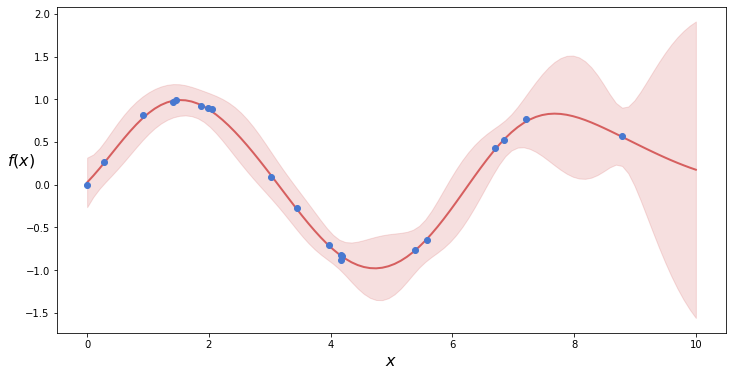

In [32]:
np.random.seed(1)
plt.figure(figsize=(12, 6))

eta, rho, sigma = 1,  0.5, 0.03

# This is the true unknown function we are trying to approximate


def f(x): return np.sin(x).flatten()

# Define the kernel


def kernel(a, b):
    """ GP squared exponential kernel """
    D = np.sum(a**2, 1).reshape(-1, 1) + np.sum(b**2, 1) - 2*np.dot(a, b.T)
    return eta * np.exp(- rho * D)


N = 20         # number of training points.
n = 100         # number of test points.

# Sample some input points and noisy versions of the function evaluated at
# these points.
X = np.random.uniform(0, 10, size=(N, 1))
y = f(X) + sigma * np.random.randn(N)

K = kernel(X, X)
L = np.linalg.cholesky(K + sigma * np.eye(N))

# points we're going to make predictions at.
Xtest = np.linspace(0, 10, n).reshape(-1, 1)

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest))
mu = np.dot(Lk.T, np.linalg.solve(L, y))

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest)
sd_pred = (np.diag(K_) - np.sum(Lk**2, axis=0))**0.5


plt.fill_between(Xtest.flat, mu - 2 * sd_pred, mu +
                 2 * sd_pred, color="r", alpha=0.2)
plt.plot(Xtest, mu, 'r', lw=2)
plt.plot(x, y, 'o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)


In [33]:
with pm.Model() as GP:
    mu = np.zeros(N)
    eta = pm.HalfCauchy('eta', 5)
    rho = pm.HalfCauchy('rho', 5)
    sigma = pm.HalfCauchy('sigma', 5)

    D = squared_distance(x, x)

    K = tt.fill_diagonal(eta * pm.math.exp(-rho * D), eta + sigma)

    obs = pm.MvNormal('obs', mu, cov=K, observed=y)

    test_points = np.linspace(0, 10, 100)
    D_pred = squared_distance(test_points, test_points)
    D_off_diag = squared_distance(x, test_points)

    K_oo = eta * pm.math.exp(-rho * D_pred)
    K_o = eta * pm.math.exp(-rho * D_off_diag)

    mu_post = pm.Deterministic('mu_post', pm.math.dot(
        pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), y))
        
    SIGMA_post = pm.Deterministic(
        'SIGMA_post', K_oo - pm.math.dot(pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), K_o.T))

    start = pm.find_MAP()
    trace = pm.sampling.sample(1000, start=start, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, rho, eta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 40 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'eta'}>,
        <AxesSubplot:title={'center':'eta'}>],
       [<AxesSubplot:title={'center':'rho'}>,
        <AxesSubplot:title={'center':'rho'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

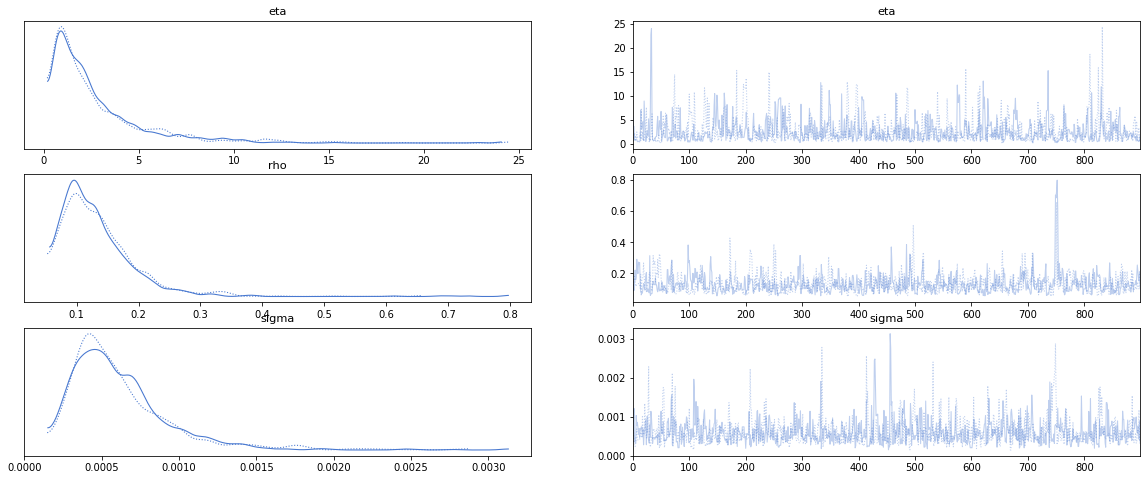

In [35]:
varnames = ['eta', 'rho', 'sigma']
chain = trace[100:]
pm.plot_trace(chain, varnames, figsize=(20, 8))

In [36]:
pm.summary(chain, varnames).round(4)

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eta,2.707,2.621,0.175,7.420,0.105,0.074,611.0,712.0,1.0
rho,0.134,0.064,0.055,0.228,0.003,0.002,584.0,765.0,1.0
sigma,0.001,0.000,0.000,0.001,0.000,0.000,813.0,832.0,1.0


Text(0, 0.5, '$f(x)$')

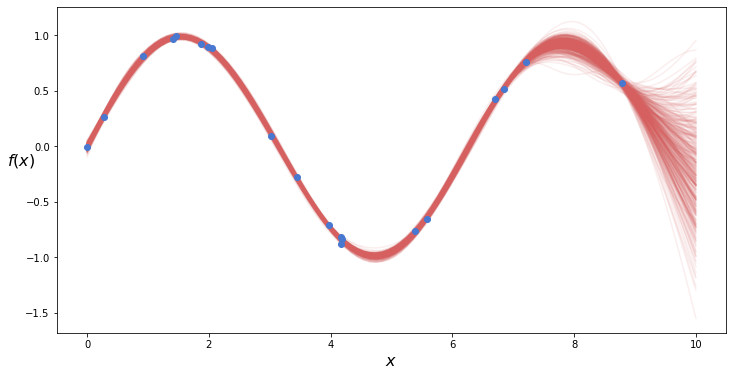

In [37]:
y_pred = [np.random.multivariate_normal(m, S) for m,S in zip(chain['mu_post'][::5], chain['SIGMA_post'][::5])]
plt.figure(figsize=(12, 6))

for yp in y_pred:
    plt.plot(test_points, yp, 'r-', alpha=0.1)

plt.plot(x, y, 'bo')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)

# Periodic Kernel

In [40]:
periodic = lambda x, y: np.array([[np.sin((x[i] - y[j])/2)**2 for i in range(len(x))] for j in range(len(y))])
periodic

<function __main__.<lambda>(x, y)>

In [41]:
with pm.Model() as GP_periodic:
    mu = np.zeros(N)
    eta = pm.HalfCauchy('eta', 5)
    rho = pm.HalfCauchy('rho', 5)
    sigma = pm.HalfCauchy('sigma', 5)

    P = periodic(x, x)

    K = tt.fill_diagonal(eta * pm.math.exp(-rho * P), eta + sigma)

    obs = pm.MvNormal('obs', mu, cov=K, observed=y)

    test_points = np.linspace(0, 10, 100)
    D_pred = periodic(test_points, test_points)
    D_off_diag = periodic(x, test_points)

    K_oo = eta * pm.math.exp(-rho * D_pred)
    K_o = eta * pm.math.exp(-rho * D_off_diag)

    mu_post = pm.Deterministic('mu_post', pm.math.dot(
        pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), y))
        
    SIGMA_post = pm.Deterministic(
        'SIGMA_post', K_oo - pm.math.dot(pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), K_o.T))

    start = pm.find_MAP()
    trace = pm.sampling.sample(1000, start=start, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, rho, eta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 34 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'eta'}>,
        <AxesSubplot:title={'center':'eta'}>],
       [<AxesSubplot:title={'center':'rho'}>,
        <AxesSubplot:title={'center':'rho'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

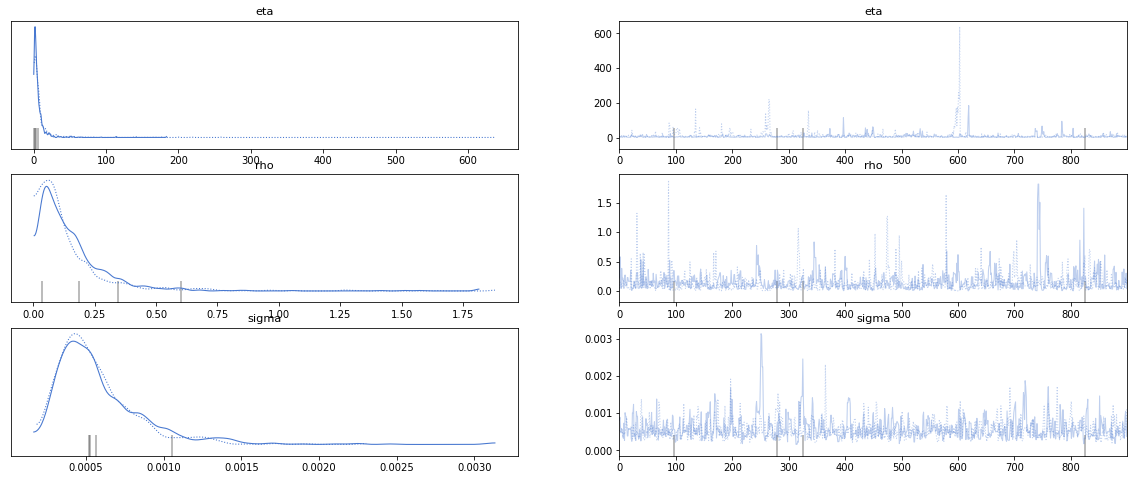

In [43]:
varnames = ['eta', 'rho', 'sigma']
chain = trace[100:]
pm.plot_trace(chain, varnames, figsize=(20, 8))

In [44]:
pm.summary(chain, varnames).round(4)

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eta,9.099,23.243,0.165,22.869,1.307,0.925,364.0,296.0,1.02
rho,0.148,0.170,0.002,0.381,0.007,0.005,406.0,310.0,1.01
sigma,0.001,0.000,0.000,0.001,0.000,0.000,780.0,663.0,1.00


Text(0, 0.5, '$f(x)$')

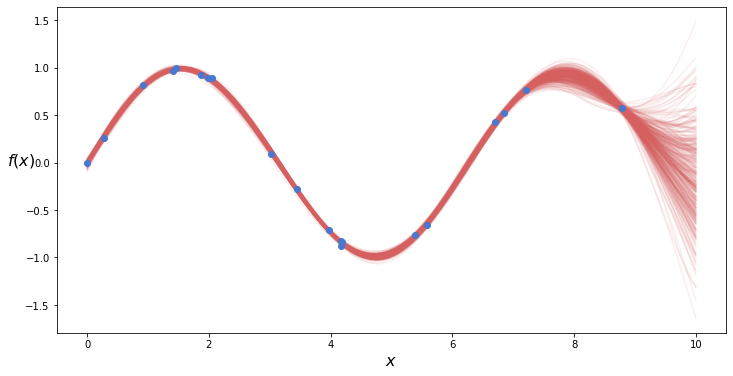

In [42]:
y_pred = [np.random.multivariate_normal(m, S) for m, S in zip(
    chain['mu_post'][::5], chain['SIGMA_post'][::5])]
plt.figure(figsize=(12, 6))

for yp in y_pred:
    plt.plot(test_points, yp, 'r-', alpha=0.1)

plt.plot(x, y, 'bo')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)
